# Investigate behaviour of 1D system

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *


## Functions

In [2]:
def test_Delta_coup(coefficient, coup_strength, hill_coeff, lattice, params, num_tsteps, dt):
    print('Coefficient:', coefficient)
    print('Coupling strength:', coup_strength)

    params.n = coefficient
    params.w_coupling = coup_strength

    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, hill_coeff, coupling_type= 'Delta', initial_type='checkerboard')

    return h, m_h, d, m_d

## Fixed parameters of the system

In [12]:
#set the lattice of the cells 
P = 20
Q = 1

lattice = get_lattice(P, Q)

# # set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 100
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.01
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)

## Varying coupling strength and Hill coefficient 

In [ ]:
coeff_1D = [1, 2, 3, 4, 5, 6]
coupling_strengths_1D = np.linspace(0, 1, int(1/0.02) + 1)

num_tsteps = 10000
dt = 0.2

hill_coeffs = [params.l, 1]

print('Hill coefficients:', coeff_1D)
print('Coupling strengths:', coupling_strengths_1D)

for k in range(2):
    results_1D = np.zeros([len(coeff_1D), len(coupling_strengths_1D), num_tsteps, lattice.P, lattice.Q, 4])
    #values for system with no Delta
    print('Calculating the no coupling system')
    h0, m_h0, d0, m_d0 = test_Delta_coup(coeff_1D[0], coupling_strengths_1D[0], hill_coeffs[k], lattice, params, num_tsteps, dt)

    for i in range(len(coeff_1D)):
        for j in range(len(coupling_strengths_1D)):

            hill_coeffs[0] = coeff_1D[i]
            print('hill coeff is', hill_coeffs[k])
            if j == 0:
                h, m_h, d, m_d = h0, m_h0, d0, m_d0
            else:
                h, m_h, d, m_d = test_Delta_coup(coeff_1D[i], coupling_strengths_1D[j], hill_coeffs[k], lattice, params, num_tsteps, dt)
            
            # Save the results in the 5D array
            results_1D[i,j,:,:,:,0] = h
            results_1D[i,j,:,:,:,1] = m_h
            results_1D[i,j,:,:,:,2] = d
            results_1D[i,j,:,:,:,3] = m_d


    # save the results to a file\
    data_dict = {
        'results_1D': results_1D,
        'coeff_1D': coeff_1D,
        'coupling_strengths_1D': coupling_strengths_1D, 
        'hill_coeff of the m_d derivative': hill_coeffs[k],
        'num_tsteps': num_tsteps,	
        'dt': dt,
        'lattice': lattice,
        'params': params,
    }

    title = f'results_delta_22_04_hc_{k}.pkl'
    
    with open(title, "wb") as file:
        pickle.dump(data_dict, file)

Hill coefficients: [1]
Coupling strengths: [0.05]
Calculating the no coupling system
Coefficient: 1
Coupling strength: 0.05


100%|██████████| 19999/19999 [01:19<00:00, 252.06it/s]


hill coeff is 1
Calculating the no coupling system
Coefficient: 1
Coupling strength: 0.05


100%|██████████| 19999/19999 [01:18<00:00, 254.00it/s]


hill coeff is 5
Calculating the no coupling system
Coefficient: 1
Coupling strength: 0.05


100%|██████████| 19999/19999 [01:18<00:00, 254.79it/s]

hill coeff is 1


### Load in data from file

In [4]:
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_delta_15_04_1D.pkl', 'rb') as f:
    data_1D = pickle.load(f)

results_1D = data_1D['results_1D']
coeff_1D = data_1D['coeff_1D']
coupling_strengths_1D = data_1D['coupling_strengths_1D']
num_tsteps = data_1D['num_tsteps']
dt = data_1D['dt']
lattice = data_1D['lattice']
params = data_1D['params'] 


In [5]:
dt

0.2

### Plots

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_4740\3157078175.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)


Error in callback <function _draw_all_if_interactive at 0x000001CE45D913F0> (for post_execute):


KeyboardInterrupt: 

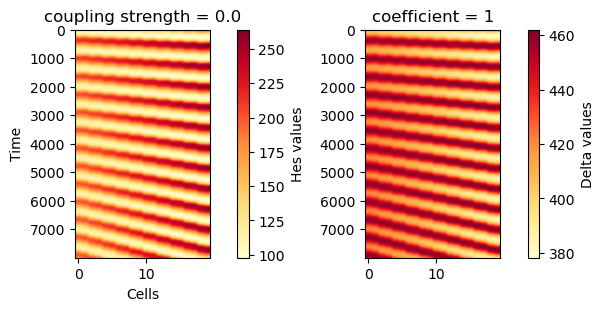

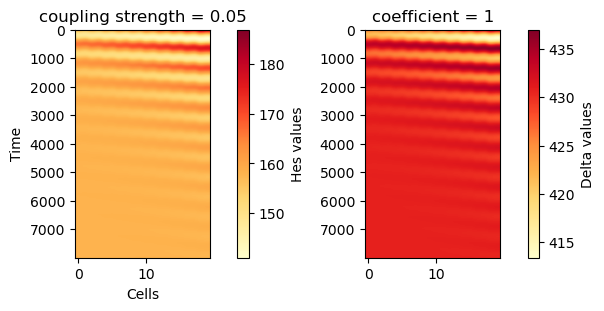

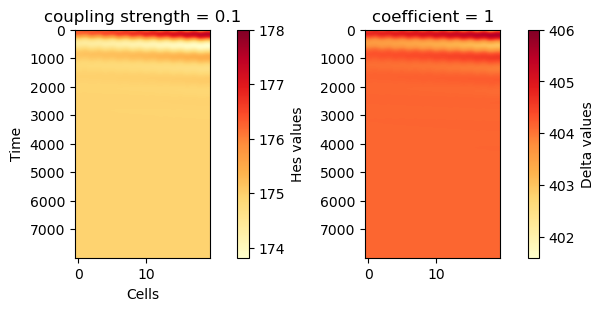

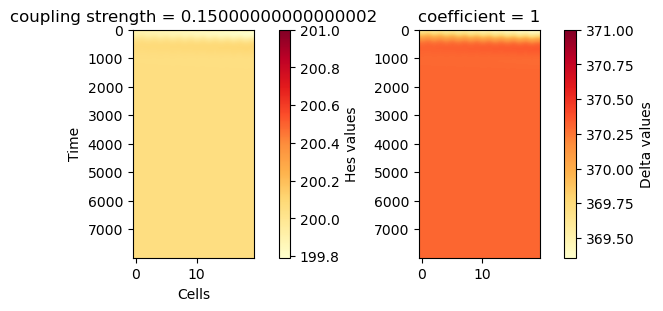

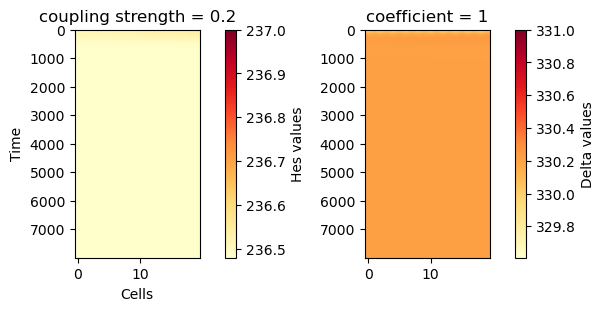

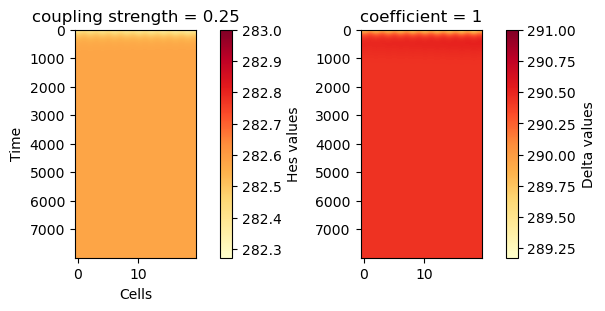

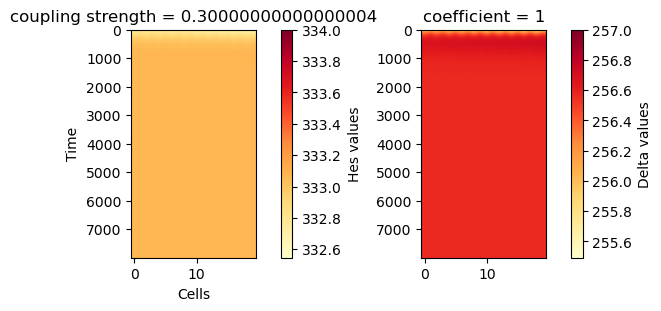

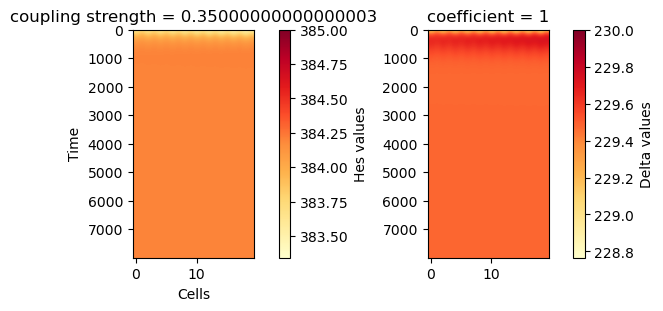

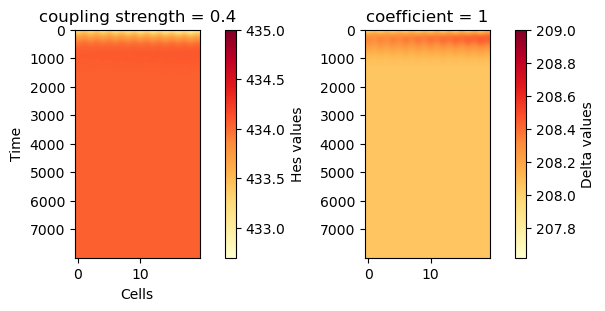

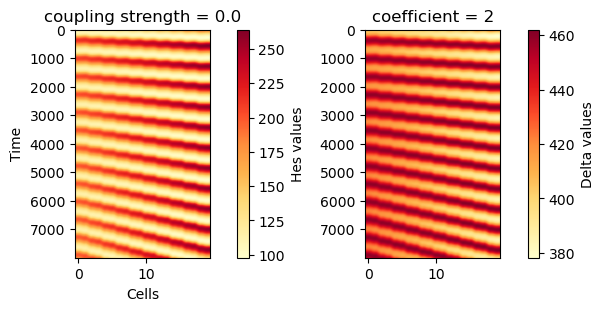

In [ ]:
# Set up the figure and two axes for vertically stacked images
for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
        h_flat = results_1D[i,j,2000:,:,0,0].reshape(num_tsteps-2000, lattice.P)
        d_flat = results_1D[i,j,2000:,:,0,2].reshape(num_tsteps-2000, lattice.P)

        # Plot the first image
        im1 = ax1.imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h_flat), vmax = np.ceil(np.max(h_flat)))
        ax1.set_ylabel('Time')
        ax1.set_xlabel('Cells')
        ax1.set_title('coupling strength = ' + str(coupling_strengths_1D[j]))

        # Add colorbar for the first image
        cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.1, pad=0.2)
        cbar1.set_label('Hes values')

        # Plot the second image
        im2 = ax2.imshow(d_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(d_flat), vmax = np.ceil(np.max(d_flat)))
        ax2.set_title('coefficient = ' + str(coeff_1D[i]))

        # Add colorbar for the second image
        cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.1, pad=0.2)
        cbar2.set_label('Delta values')

        #fig.savefig('1D_h_d_coeff_' + str(coeff_1D[i]) + '_coup_' + str(coupling_strengths_1D[j]) + '.png', dpi=300, bbox_inches='tight')

### Observable: period

In [54]:
def smoothen_signal(signal, window_size=5):
    """
    Smoothen a 1D signal using a moving average filter.

    Parameters:
    - signal: 1D numpy array of the signal values
    - window_size: Size of the moving window (default is 5)

    Returns:
    - smoothed_signal: Smoothed signal (1D numpy array)
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    
    # Create the moving average filter
    kernel = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(signal, kernel, mode='same')

    return smoothed_signal

def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    if time is None:
        # Assume uniform spacing
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 4:
        period = -1000  # Not enough peaks to estimate period

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

def estimate_period_fft(signal, time=None, detrend=False):
    """
    Estimate the dominant period of a signal using Fourier Transform.

    Parameters:
    - signal: 1D array of signal values
    - time: 1D array of time values (if None, assume uniform time steps)
    - detrend: Remove the mean before FFT to reduce DC offset

    Returns:
    - period: Estimated dominant period
    - freqs: Frequencies used
    - power: Power spectrum
    """
    if time is None:
        dt = 1.0  # assume uniform spacing of 1
        time = np.arange(len(signal))
    else:
        dt = np.mean(np.diff(time))  # average time step

    if detrend:
        signal = signal - np.mean(signal)  # remove DC component

    # Perform FFT
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)

    # Use only positive frequencies
    pos_mask = fft_freqs > 0
    freqs = fft_freqs[pos_mask]
    power = np.abs(fft_vals[pos_mask])**2

    # Find the peak frequency
    peak_idx = np.argmax(power)
    dominant_freq = freqs[peak_idx]
    period = 1 / dominant_freq

    return period, freqs, power

def estimate_period_autocorr(signal, time=None, detrend=False, height = None, min_period=1):
    """
    Estimate the dominant period of a signal using autocorrelation.

    Parameters:
    - signal: 1D array of the signal values
    - time: 1D array of time points (optional, required for real period values)
    - detrend: Whether to subtract the mean (removes DC offset)
    - min_period: Minimum time (or index) to consider between peaks

    Returns:
    - estimated_period: Dominant period (in time units if time is provided)
    - lags: Lag values
    - autocorr: Autocorrelation values
    """
    n = len(signal)

    if detrend:
        signal = signal - np.mean(signal)

    # Full autocorrelation, symmetric around center
    autocorr_full = correlate(signal, signal, mode='full')
    autocorr = autocorr_full[n-1:]  # second half only
    autocorr /= autocorr[0]  # normalize

    lags = np.arange(len(autocorr))

    # Find peaks in autocorrelation
    peaks, _ = find_peaks(autocorr, distance=min_period, height=height)

    if len(peaks) < 1:
        return None, lags, autocorr  # No peaks found

    dominant_lag = peaks[0]

    if time is not None:
        dt = np.mean(np.diff(time))
        estimated_period = dominant_lag * dt
    else:
        estimated_period = dominant_lag  # in sample units

    return estimated_period, lags, autocorr

def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
    """
    Estimate amplitude by detecting peaks and computing average peak height.

    Parameters:
    - signal: 1D numpy array
    - height, distance, prominence: Optional arguments for peak detection

    Returns:
    - amplitude: Estimated amplitude
    - peak_values: Values of detected peaks
    - trough_values: Values of detected troughs
    """
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    peak_values = signal[peaks]
    trough_values = signal[troughs]

    if len(peak_values) == 0 or len(trough_values) == 0:
        return None, peak_values, trough_values  # Not enough data

    avg_peak = np.mean(peak_values)
    avg_trough = np.mean(trough_values)
 
    amplitude = 0.5 * (avg_peak - avg_trough)
    return amplitude, peak_values, trough_values

def decay_ratio(signal, time_frame=360, height=None, distance=None, prominence=None):
    time_frame_steps = int(time_frame / dt)

    # Detect peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    
    if len(peaks) < 2:
        return 100  # Not enough peaks

    # Calculate distances from the first peak
    peak_distances = peaks - peaks[0]
    mask = peak_distances > time_frame_steps

    if not np.any(mask):
        return 100  # No second peak far enough away

    # Get the first peak that satisfies the condition
    index = np.argmax(mask)

    peak_start = peaks[0]
    peak_end = peaks[index]

    peak_values_start = signal[peak_start]
    peak_values_end = signal[peak_end]

    # Check for invalid division
    if peak_values_end <= 0:
        return 100
    return peak_values_start / peak_values_end


### Fix constant part of signal

In [55]:
time_analysis = int(2000)
time_amplitude = int(3*num_tsteps/4)

### Example of a decaying signal

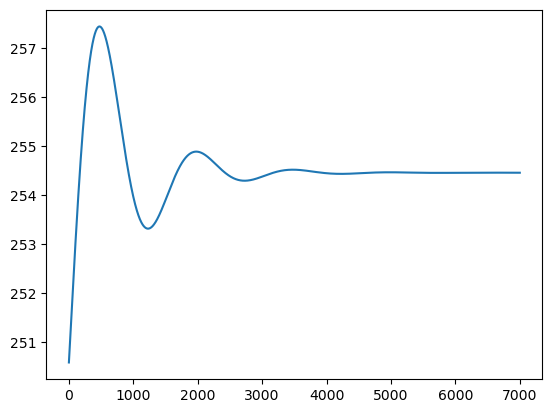

In [51]:
signal = results_1D[1,5,3000:,5,0,0].reshape(num_tsteps-3000)
plt.plot(signal.flatten())

### Calculate decay ratios for the results

In [ ]:
decay_ratios = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for k in range(lattice.P):
            signal = results_1D[i,j,time_analysis:,k,0,0].reshape(num_tsteps-time_analysis)
            signal = signal - np.mean(signal)
            signal = signal.flatten()  # remove DC component

            decay_ratios[i,j,k] = decay_ratio(signal, time_frame = 600)
    

# take the mean over all cells in P direction
decay_ratio_means = np.mean(decay_ratios, axis = 2)


### Calculate periods for the results

In [ ]:
# find periods for the 1D system, per cell 
periods_peaks = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])
# periods_fft = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])
# periods_autocorr = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])


for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for p in range(lattice.P):
            signal = results_1D[i,j,time_analysis:,p,0,0].flatten()
            
            # find the period of the oscillation for each cell
            periods_peaks[i,j,p]= estimate_period_from_peaks(signal, time = np.arange(int(num_tsteps - time_analysis))*dt)[0]
            #periods_fft[i,j,p] = estimate_period_fft(signal, time = np.arange(int(num_tsteps - time_analysis))*dt)[0]
            #periods_autocorr[i,j,p] = estimate_period_autocorr(signal, time = np.arange(int(num_tsteps - time_analysis))*dt, height=None)[0]
            # amplitudes[i,j,p] = estimate_amplitude_from_peaks(signal, height=amplitude_threshold)[0]
            #amplitudes[i,j,p] = estimate_amplitude_from_peaks(signal)[0]

# calculate the average period of the signal over all cells
period_peaks_avg = np.mean(periods_peaks, axis = 2)

### Calculate amplitude for the last peaks of signal

In [57]:
amplitudes = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for k in range(lattice.P):
            signal = results_1D[i,j,time_amplitude:,k,0,0].flatten()

            amplitudes[i,j,k] = estimate_amplitude_from_peaks(signal)[0]

amplitudes_mean = np.mean(amplitudes, axis =2)

### Calculate the phase gradient of the system 

(20,)
[-0.46251851 -0.12452407 -0.14202718  0.02380759  0.01614219  0.12889138
  0.14178715  0.20200005  0.23952683  0.23852148  0.29406933  0.22646003
  0.28425278  0.14733868  0.18856255 -0.01933975 -0.00511933 -0.29110661
 -0.29462867 -0.78205302]
[ 586 1302 2015 2727 3439 4150 4862 5574 6285 6997 7708]
phase gradient is [ 0.33799444  0.16024566  0.07416583  0.07908469  0.0525419   0.06282248
  0.03655434  0.04886984  0.01826072  0.02727125 -0.00603073 -0.00490827
 -0.03956068 -0.04784512 -0.08333921 -0.09684094 -0.13588343 -0.14475467
 -0.2454732  -0.48742435]


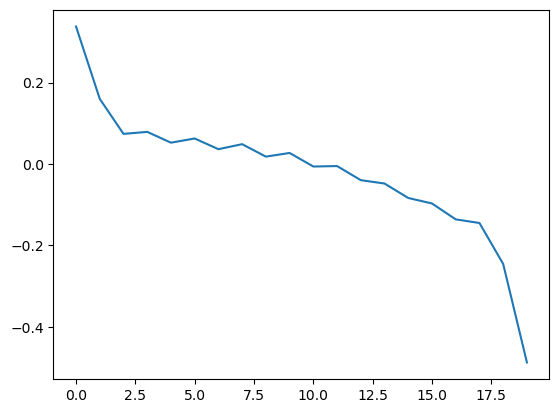

In [ ]:
signal_matrix = results_1D[0,0,3000,:,0,0]
print(signal_matrix.shape)
# signal_matrix: shape (n_cells, n_timepoints)
analytic_signal = hilbert(signal_matrix, axis=0)
instantaneous_phase = np.angle(analytic_signal)  # phase at each time
print(instantaneous_phase)

signal_matrix_peaks = results_1D[0,0,time_analysis:,:,0,0]

for p in range(lattice.P):
    peaks, _ = find_peaks(signal_matrix_peaks[:,p])
    peak_values = signal_matrix_peaks[peaks]

# # Optionally average over a time window
# mean_phase = np.mean(instantaneous_phase[:, start:end], axis=1)

# # Compute gradient
# phase_gradient = np.gradient(mean_phase, dx)
phase_gradient = np.gradient(instantaneous_phase)
print('phase gradient is', phase_gradient)

plt.plot(phase_gradient)

In [ ]:
signal_matrix = results_1D[4,3,3000:,:,0,0]
# Your signal: shape (n_timepoints, n_cells)
# Step 1: Apply Hilbert transform along time (axis=0)
analytic_signal = hilbert(signal_matrix, axis=0)

# Step 2: Get instantaneous phase (still shape: n_timepoints × n_cells)
instantaneous_phase = np.angle(analytic_signal)

# Step 3: (Optional) Average over a time window
# Example: average from time index 1000 to 2000
mean_phase = np.mean(instantaneous_phase[1000:2000, :], axis=0)  # axis=0 → averaging over time

# Step 4: Compute spatial phase gradient (along cells)
# dx = spacing between cells (in spatial units; use 1 if uniform and unknown)
dx = 1
phase_gradient = np.gradient(mean_phase, dx)

unwrapped_phase = np.unwrap(instantaneous_phase, axis=0)
phase_gradient_time_resolved = np.gradient(unwrapped_phase, axis=1) / dx

total_phase_shift = np.sum(np.gradient(mean_phase_unwrapped, dx))

[ 0.00266313  0.0014172   0.00202973 ... -0.00148674 -0.00089648
  0.00170965]


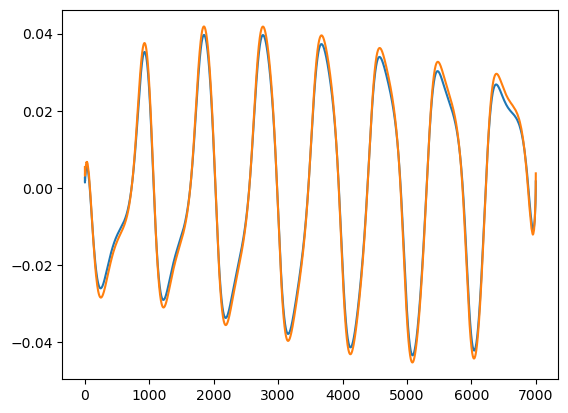

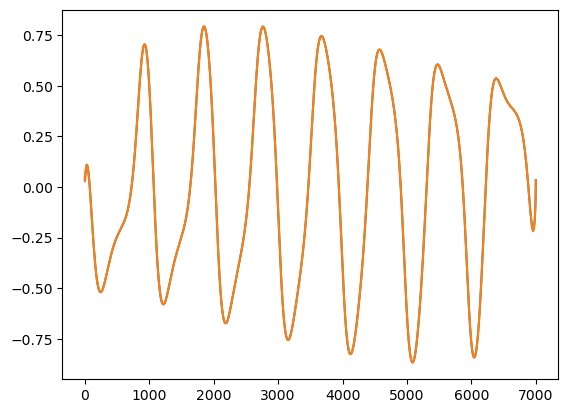

In [103]:
total_phase_gradient_2 = np.mean(phase_gradient_time_resolved, axis=1)
print(total_phase_gradient_2)
plt.plot(total_phase_gradient_2)

total_phase_gradient = (unwrapped_phase[:,-1] - unwrapped_phase[:,0]) / (lattice.P - 1)
plt.plot(total_phase_gradient)

total_phase_gradient_3 = np.sum(phase_gradient_time_resolved, axis = 1)
plt.figure()
plt.plot(total_phase_gradient_3)

total_phase_gradient_4 = np.sum(phase_gradient_time_resolved[:,5:-5], axis = 1)
plt.plot(total_phase_gradient_3)

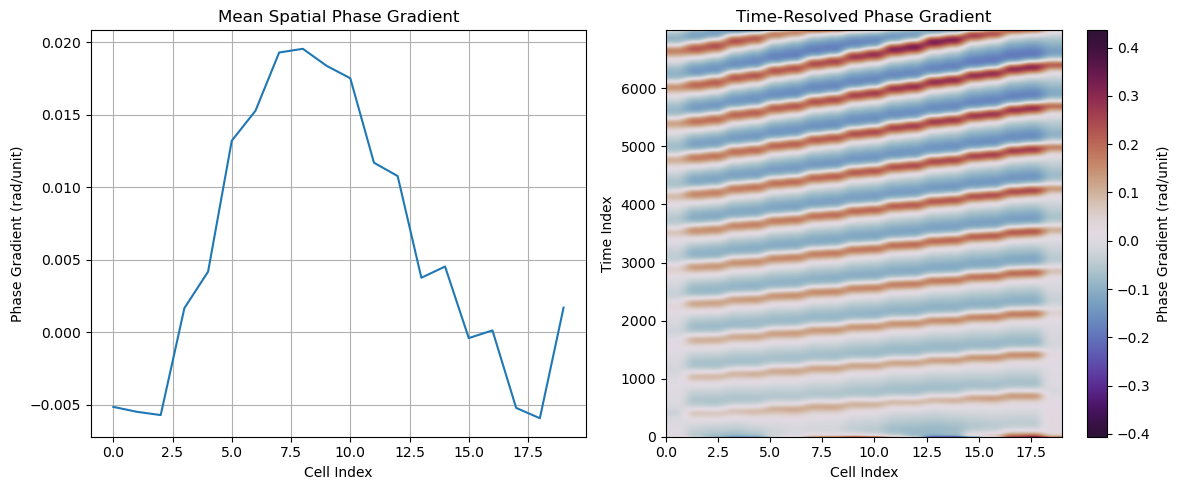

In [81]:
# Plot mean phase gradient
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(phase_gradient)
plt.title("Mean Spatial Phase Gradient")
plt.xlabel("Cell Index")
plt.ylabel("Phase Gradient (rad/unit)")
plt.grid(True)

# Plot time-resolved phase gradient
plt.subplot(1, 2, 2)
im = plt.imshow(phase_gradient_time_resolved, 
                aspect='auto', 
                origin='lower', 
                cmap='twilight_shifted',
                extent=[0, signal_matrix.shape[1]-1, 0, signal_matrix.shape[0]-1])
plt.colorbar(im, label='Phase Gradient (rad/unit)')
plt.title("Time-Resolved Phase Gradient")
plt.xlabel("Cell Index")
plt.ylabel("Time Index")

plt.tight_layout()
plt.show()

In [91]:
total_phase_gradient = (unwrapped_phase[:,-1] - unwrapped_phase[:,0]) / (lattice.P - 1)

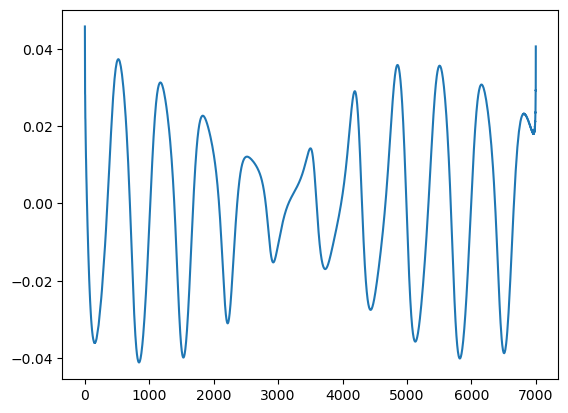

In [92]:
plt.plot(total_phase_gradient)

(20,)
[-0.46251851 -0.12452407 -0.14202718  0.02380759  0.01614219  0.12889138
  0.14178715  0.20200005  0.23952683  0.23852148  0.29406933  0.22646003
  0.28425278  0.14733868  0.18856255 -0.01933975 -0.00511933 -0.29110661
 -0.29462867 -0.78205302]
phase gradient is [ 0.33799444  0.16024566  0.07416583  0.07908469  0.0525419   0.06282248
  0.03655434  0.04886984  0.01826072  0.02727125 -0.00603073 -0.00490827
 -0.03956068 -0.04784512 -0.08333921 -0.09684094 -0.13588343 -0.14475467
 -0.2454732  -0.48742435]
(20,)
[-0.06138987 -0.00942108 -0.01180072  0.00582346  0.00540208  0.01405956
  0.01496872  0.01808963  0.01997243  0.01860968  0.02111728  0.01578023
  0.01850203  0.00954093  0.01196819 -0.00052422  0.00092891 -0.01647986
 -0.01715513 -0.05801682]
phase gradient is [ 0.05196879  0.02479458  0.00762227  0.0086014   0.00411805  0.00478332
  0.00201504  0.00250186  0.00026003  0.00057242 -0.00141473 -0.00130763
 -0.00311965 -0.00326692 -0.00503258 -0.00551964 -0.00797782 -0.0090420

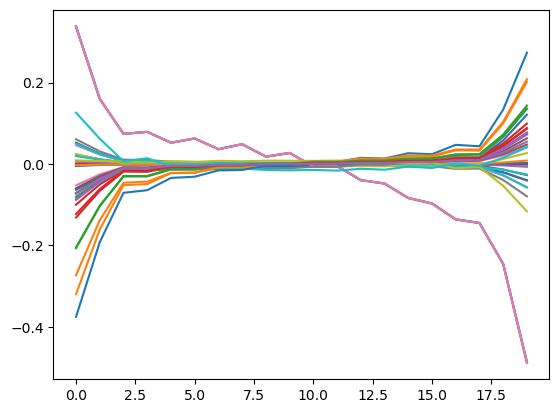

In [69]:
from scipy.signal import hilbert

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
            signal_matrix = results_1D[i,j,3000,:,0,0]
            print(signal_matrix.shape)
            # signal_matrix: shape (n_cells, n_timepoints)
            analytic_signal = hilbert(signal_matrix, axis=0)
            instantaneous_phase = np.angle(analytic_signal)  # phase at each time
            print(instantaneous_phase)
            
            # # Optionally average over a time window
            # mean_phase = np.mean(instantaneous_phase[:, start:end], axis=1)

            # # Compute gradient
            # phase_gradient = np.gradient(mean_phase, dx)
            phase_gradient = np.gradient(instantaneous_phase)
            print('phase gradient is', phase_gradient)

            plt.plot(phase_gradient)

### Plot the mean decay rate, period and final amplitude

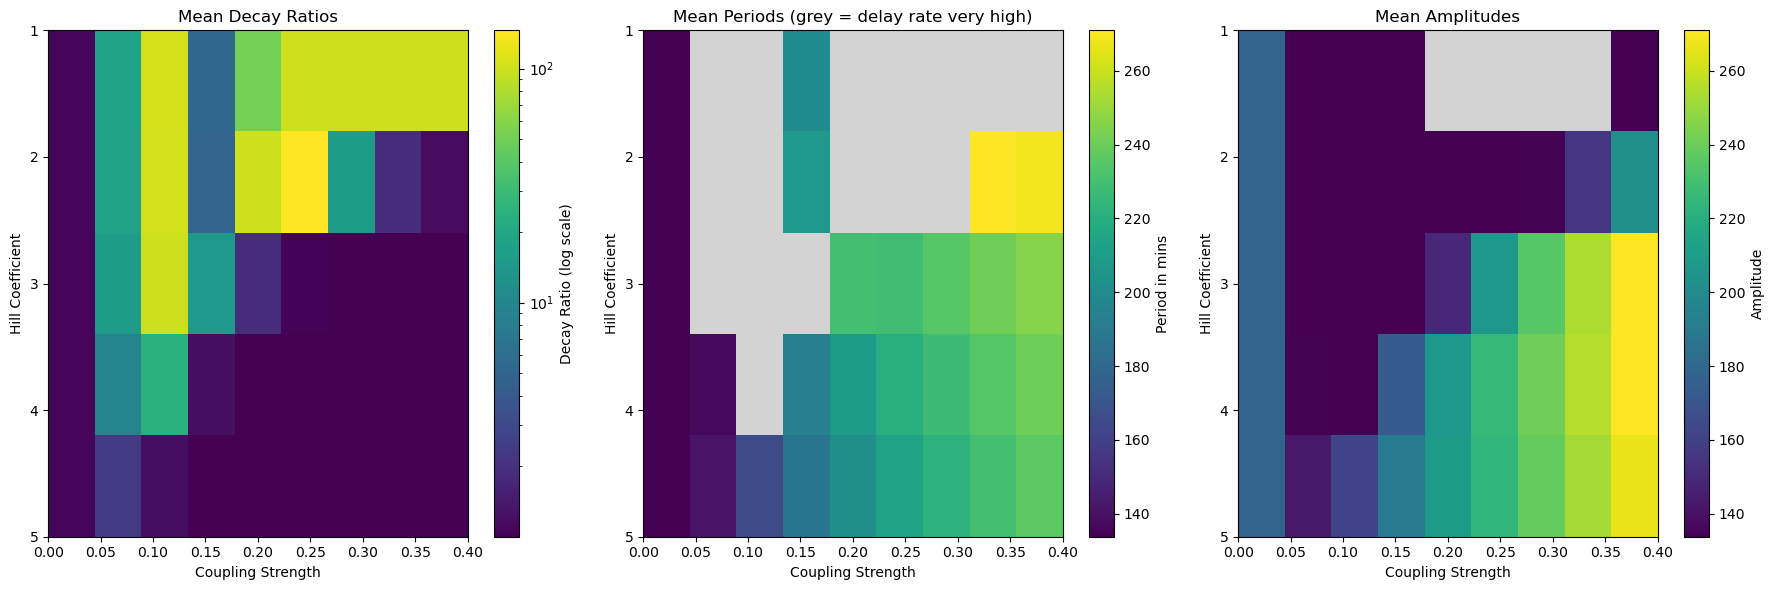

In [62]:
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ======== Plot 1: Decay Ratios (log scale) ========
im1 = axes[0].imshow(decay_ratio_means, 
                     aspect='auto', 
                     interpolation='none', 
                     norm=LogNorm(vmin=np.min(decay_ratio_means[decay_ratio_means > 0]), 
                                  vmax=np.max(decay_ratio_means)),
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])
axes[0].set_title('Mean Decay Ratios')
axes[0].set_xlabel('Coupling Strength')
axes[0].set_ylabel('Hill Coefficient')
axes[0].set_yticks([1, 2, 3, 4, 5])
fig.colorbar(im1, ax=axes[0], label='Decay Ratio (log scale)')

# ======== Plot 2: Periods (masked by decay) ========
masked_periods = np.ma.masked_where(decay_ratio_means > 10, period_peaks_avg)
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')

im2 = axes[1].imshow(masked_periods, 
                     aspect='auto', 
                     interpolation='none', 
                     cmap=cmap,
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])

axes[1].set_title('Mean Periods (grey = delay rate very high)')
axes[1].set_xlabel('Coupling Strength')
axes[1].set_ylabel('Hill Coefficient')
axes[1].set_yticks([1, 2, 3, 4, 5])
fig.colorbar(im2, ax=axes[1], label='Period in mins')

# ======== Plot 3: Amplitudes ========
im3 = axes[2].imshow(amplitudes_mean, 
                     aspect='auto', 
                     interpolation='none', 
                     cmap=cmap,
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])

axes[2].set_title('Mean Amplitudes')
axes[2].set_xlabel('Coupling Strength')
axes[2].set_ylabel('Hill Coefficient')
axes[2].set_yticks([1, 2, 3, 4, 5])
fig.colorbar(im2, ax=axes[2], label='Amplitude')

plt.tight_layout()
plt.show()

#### All plots for decay ratio

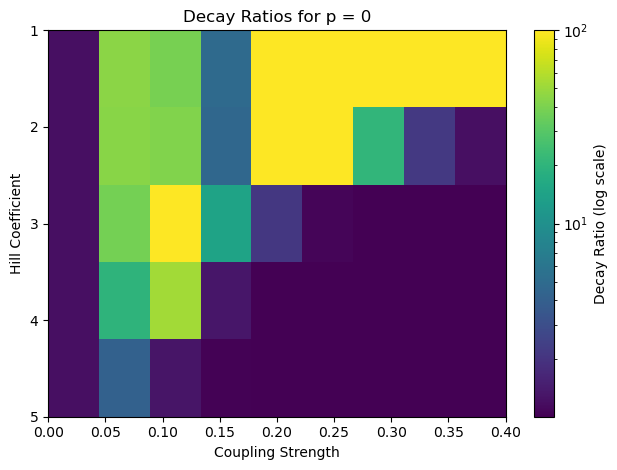

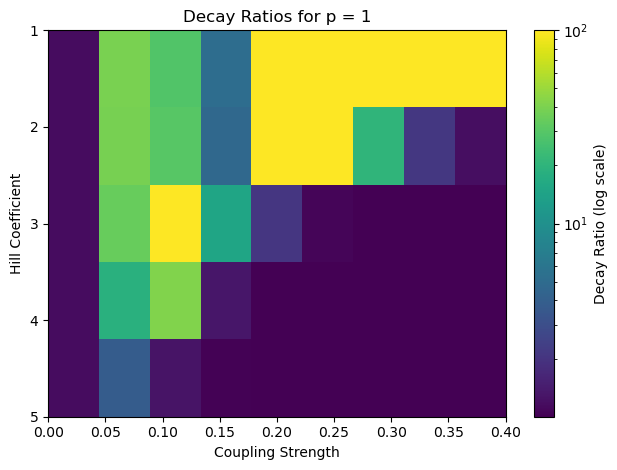

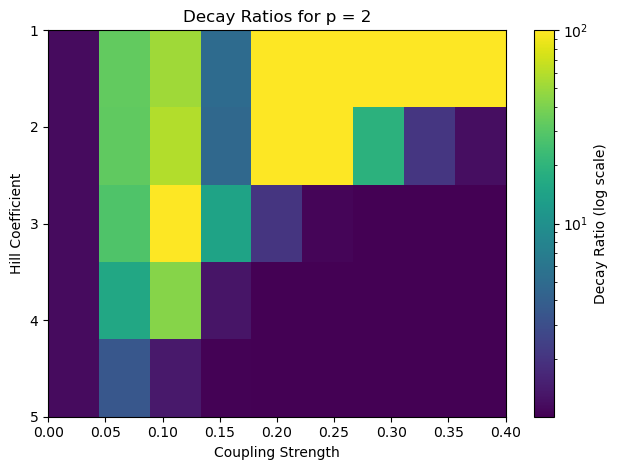

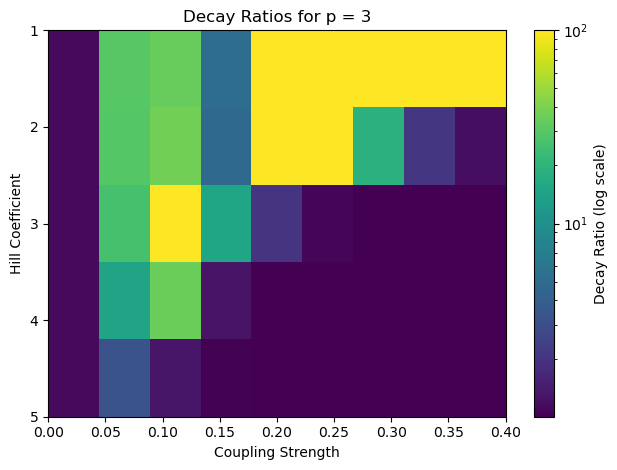

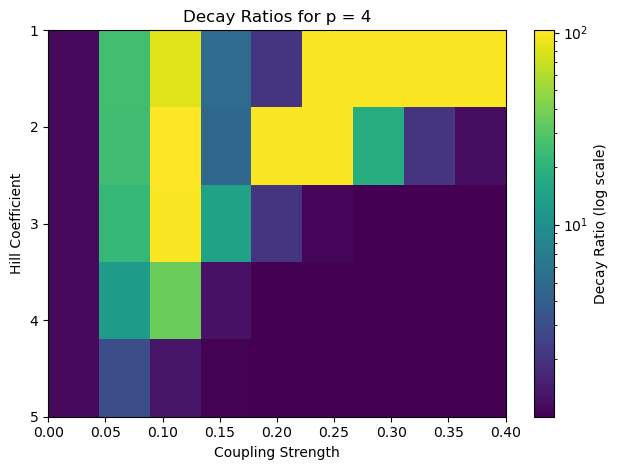

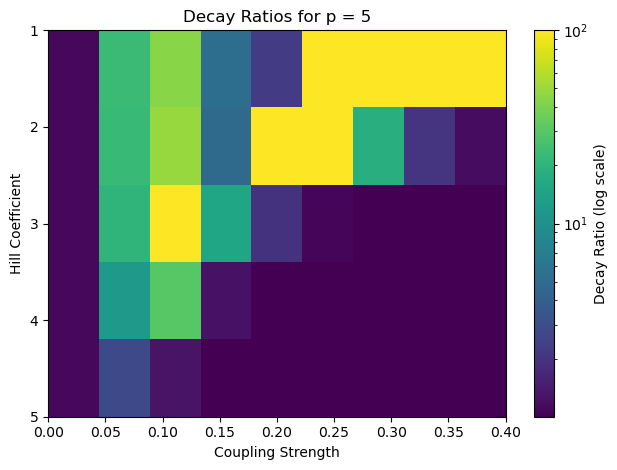

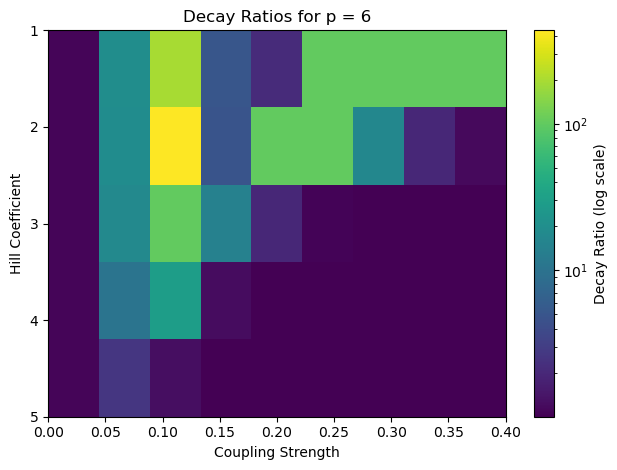

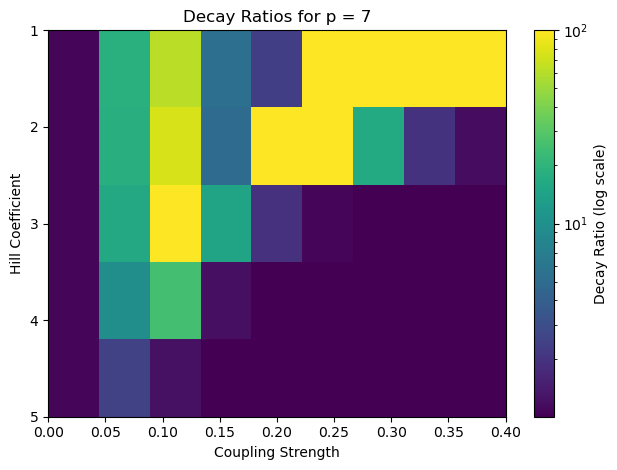

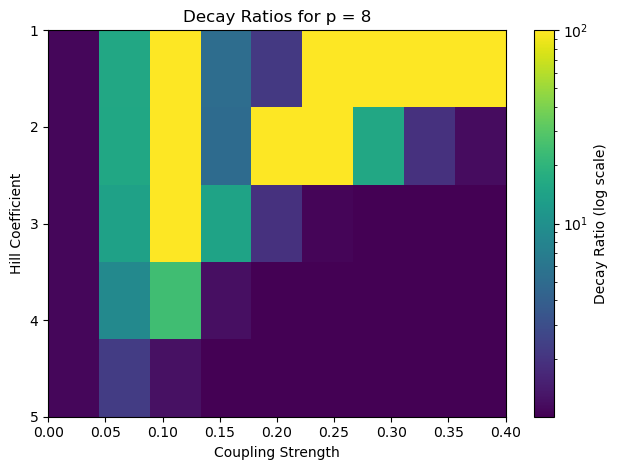

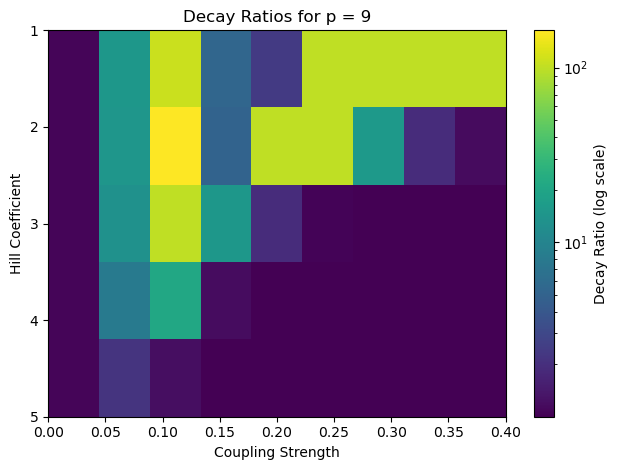

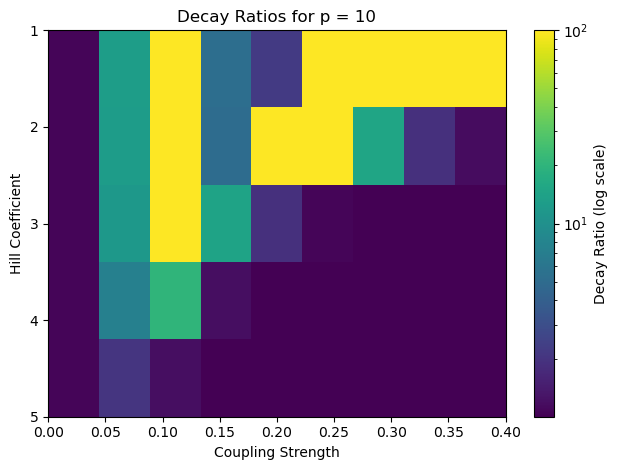

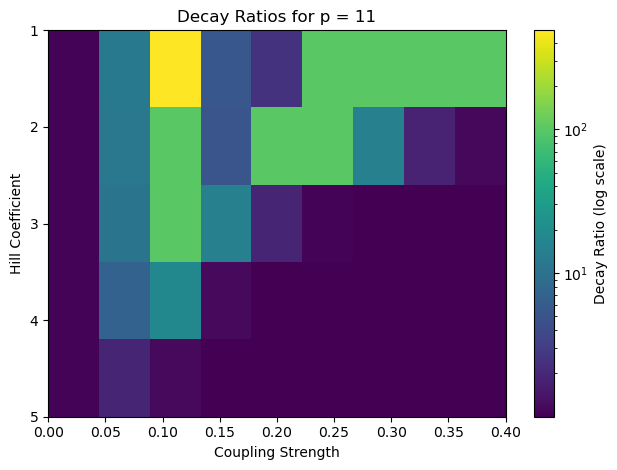

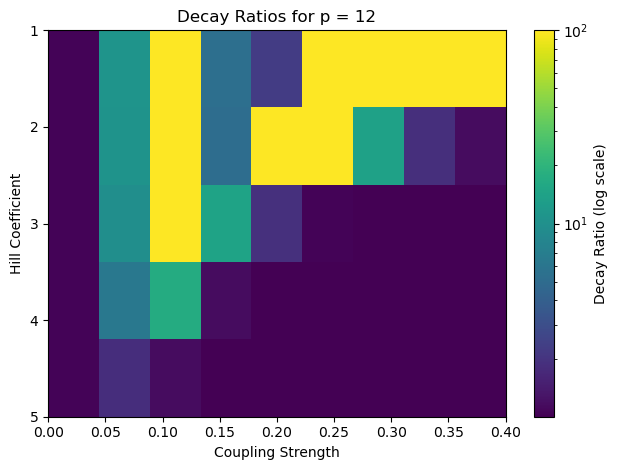

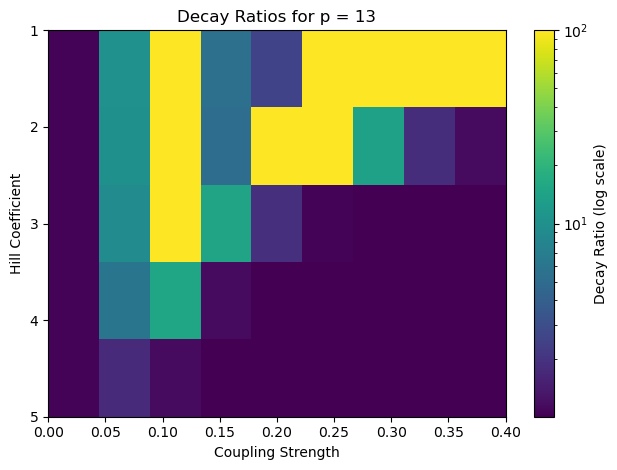

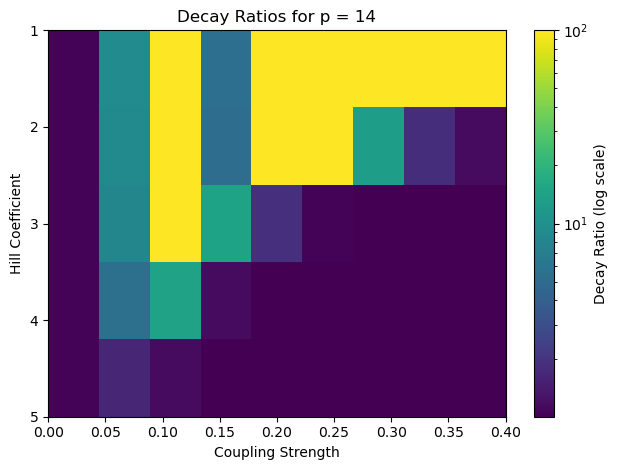

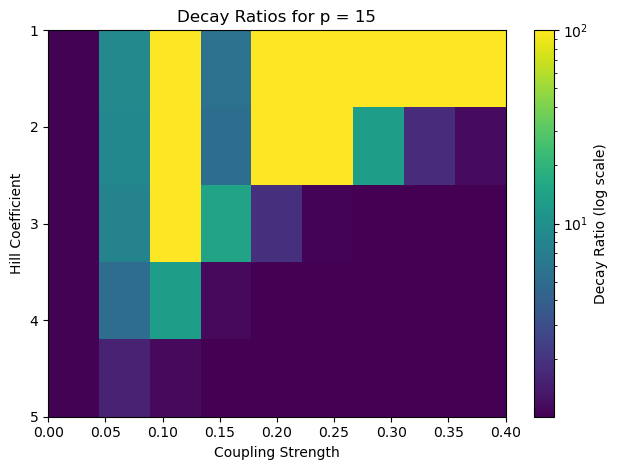

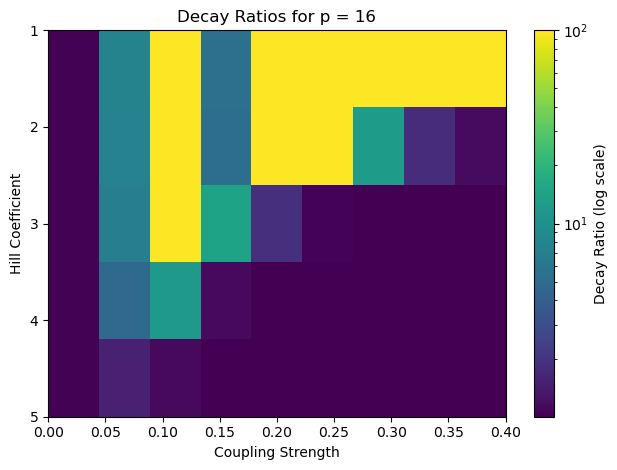

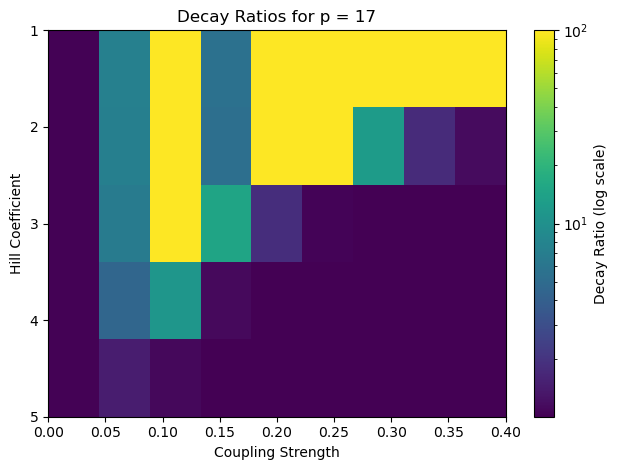

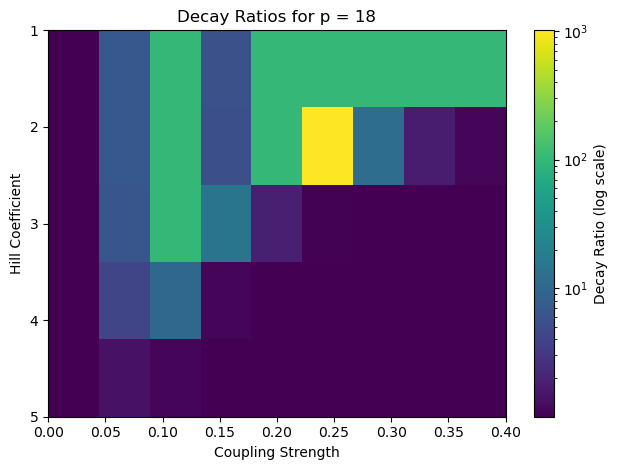

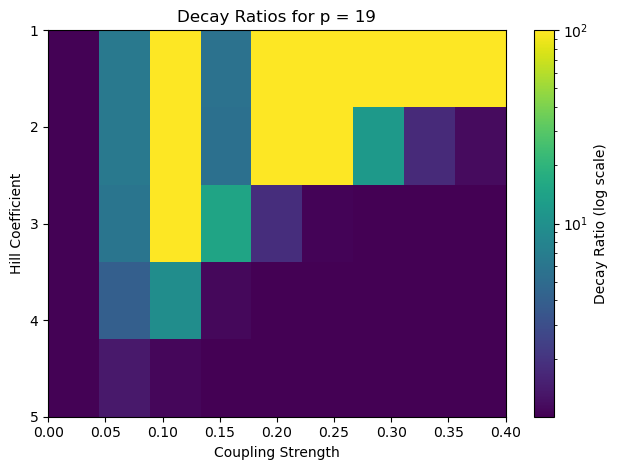

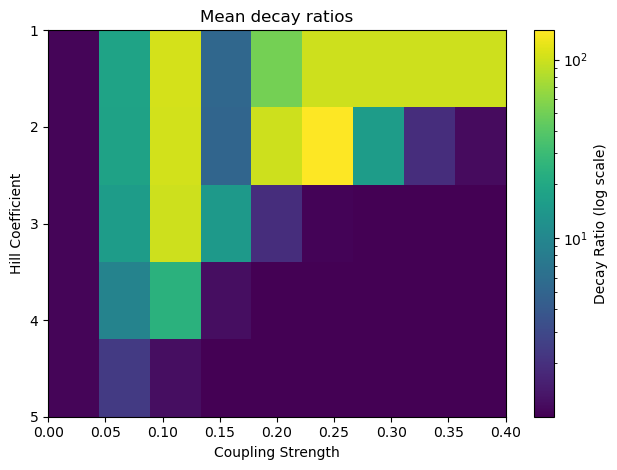

In [ ]:

for k in range(lattice.P): 
    decay_ratio_k = decay_ratios[:,:,k]

    plt.figure()

    # Apply logarithmic color scale
    plt.imshow(decay_ratio_k, 
            aspect='auto', 
            interpolation='none', 
            norm=LogNorm(vmin=np.min(decay_ratio_k[decay_ratio_k > 0]), vmax=np.max(decay_ratio_k)),
            extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], coeff_1D[-1], coeff_1D[0]])

    plt.colorbar(label='Decay Ratio (log scale)')
    plt.xlabel('Coupling Strength')
    plt.ylabel('Hill Coefficient')
    plt.title(f'Decay Ratios for p = {k}')

    # Set y-ticks explicitly
    plt.yticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.show()

plt.figure()


# Apply logarithmic color scale
plt.imshow(decay_ratio_means, 
        aspect='auto', 
        interpolation='none', 
        norm=LogNorm(vmin=np.min(decay_ratio_means[decay_ratio_means > 0]), vmax=np.max(decay_ratio_means)),
        extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], coeff_1D[-1], coeff_1D[0]])

plt.colorbar(label='Decay Ratio (log scale)')
plt.xlabel('Coupling Strength')
plt.ylabel('Hill Coefficient')
plt.title(f'Mean decay ratios')

# Set y-ticks explicitly
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

#### All plots for peak period

In [ ]:
for k in range(lattice.P): 
    periods_k = periods_peaks[:,:,k]
    
    plt.figure()

    # Apply logarithmic color scale
    plt.imshow(periods_k, 
            aspect='auto', 
            interpolation='none')

    plt.colorbar(label='Period in mins')
    plt.xlabel('Coupling Strength')
    plt.ylabel('Hill Coefficient')
    plt.title(f'Periods p = {k}')

    # Set y-ticks explicitly
    plt.yticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.show()

plt.figure()

# take the mean over all cells in P direction

# Apply logarithmic color scale
plt.imshow(period_peaks_avg, 
        aspect='auto', 
        interpolation='none')

plt.colorbar(label='Period in mins')
plt.xlabel('Coupling Strength')
plt.ylabel('Hill Coefficient')
plt.title(f'Mean periods')

# Set y-ticks explicitly
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

### Different types of period calculation

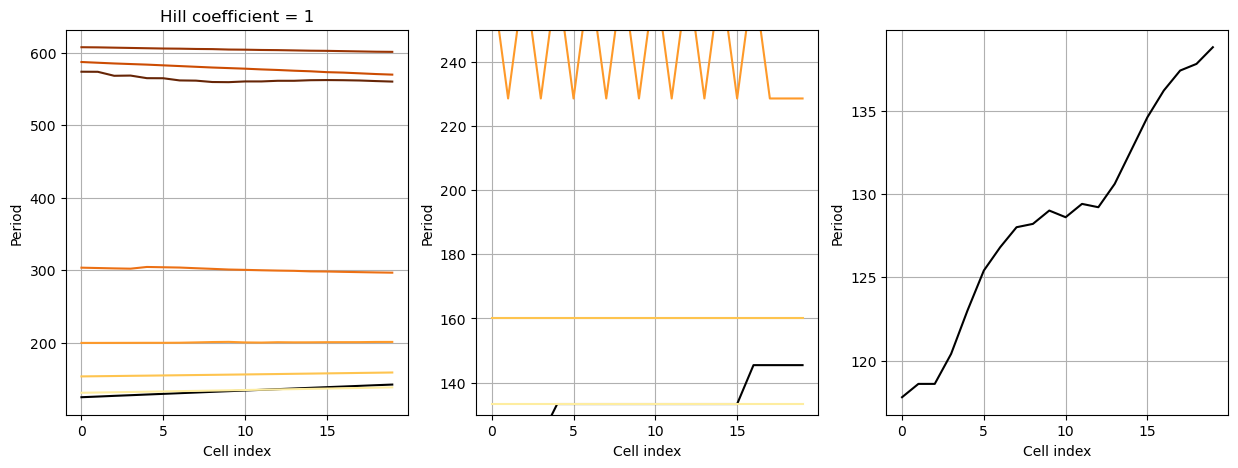

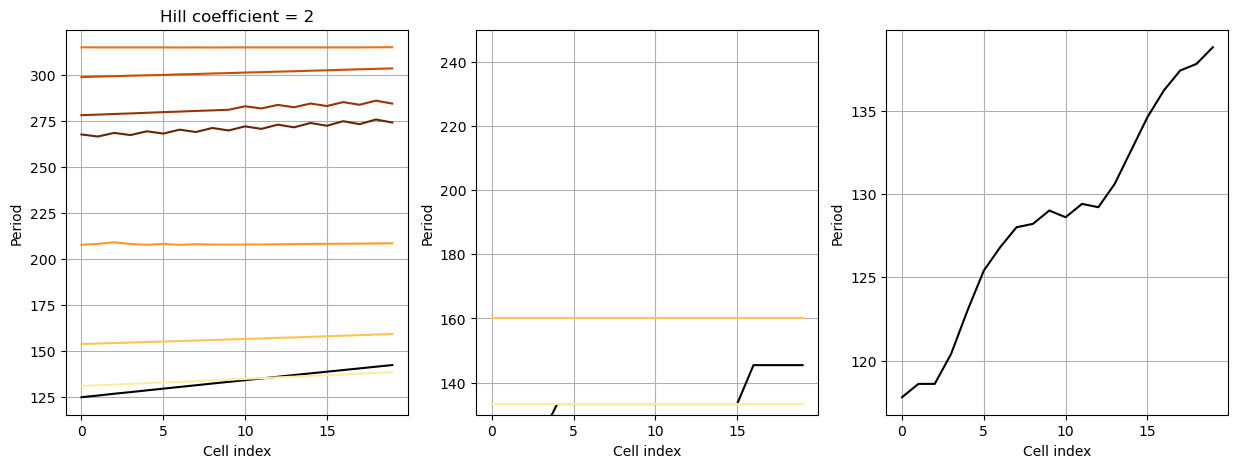

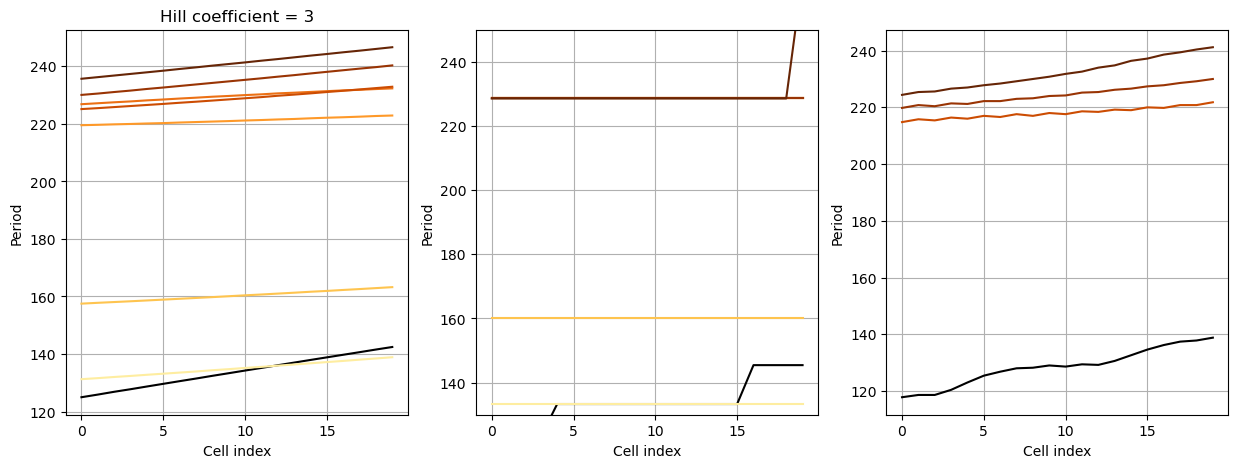

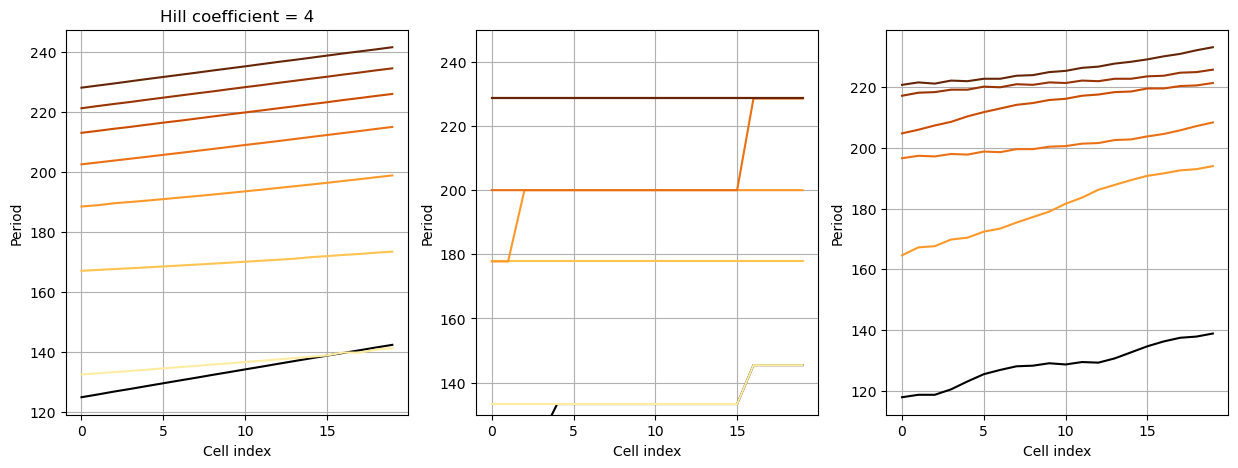

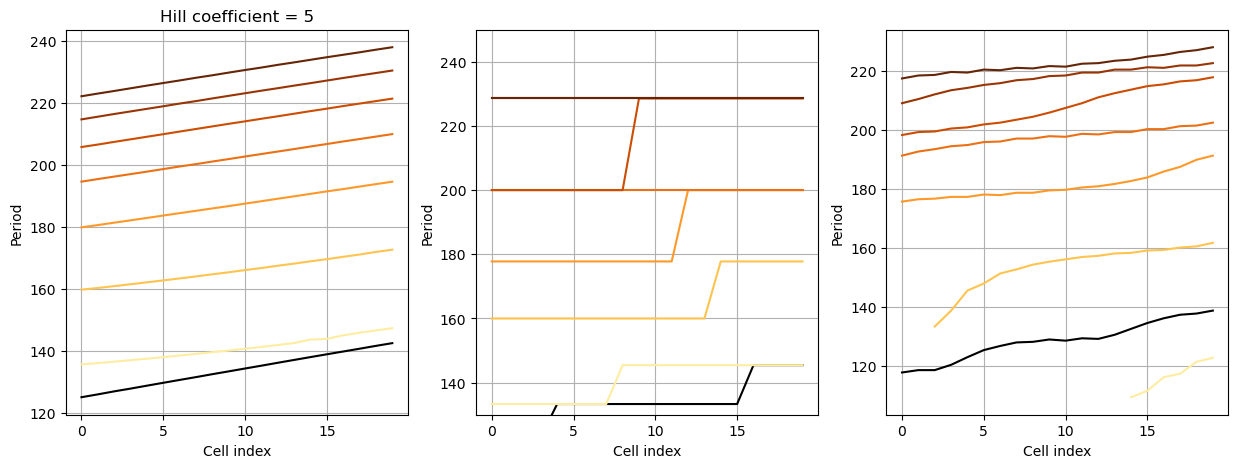

In [7]:
colors_coeffs = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
colors_strengths = ['#feeda0', '#fec44f', '#fe9929', '#ec7014', '#cc4c02', '#993404', '#662506']


for i in range(len(coeff_1D)):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(lattice.P), periods_peaks[0,0,:], label = 'no coupling periods', color = 'black')
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()
    
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_peaks[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.title(f'Hill coefficient = {coeff_1D[i]}')


    plt.subplot(1,3,2)
    plt.plot(np.arange(lattice.P), periods_fft[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_fft[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.ylim(130,250)
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(np.arange(lattice.P), periods_autocorr[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_autocorr[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')

    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()

### Plot periods + amplitude + kymograph for each n

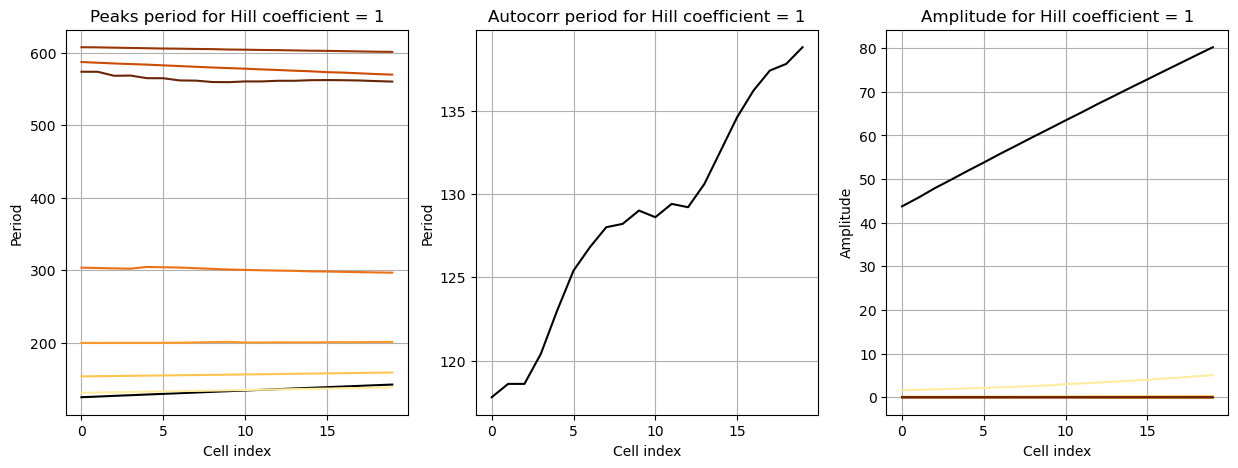

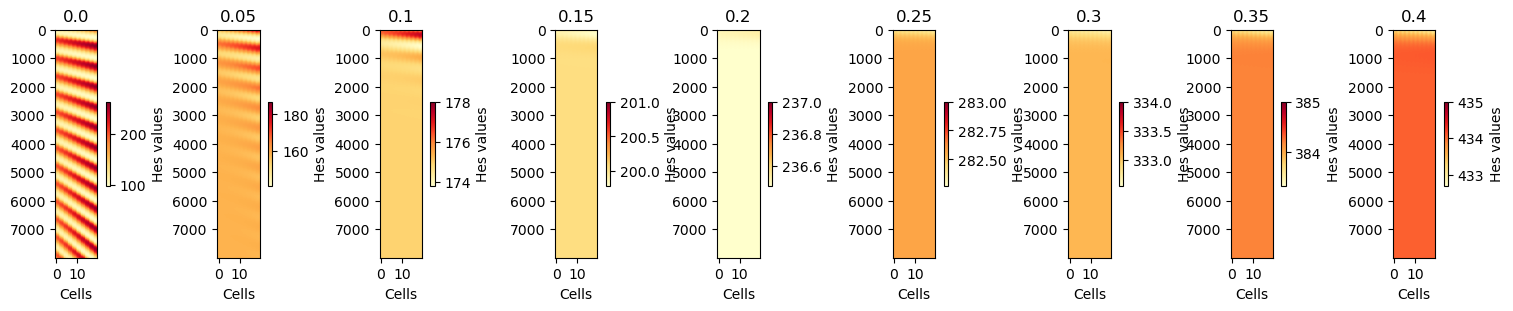

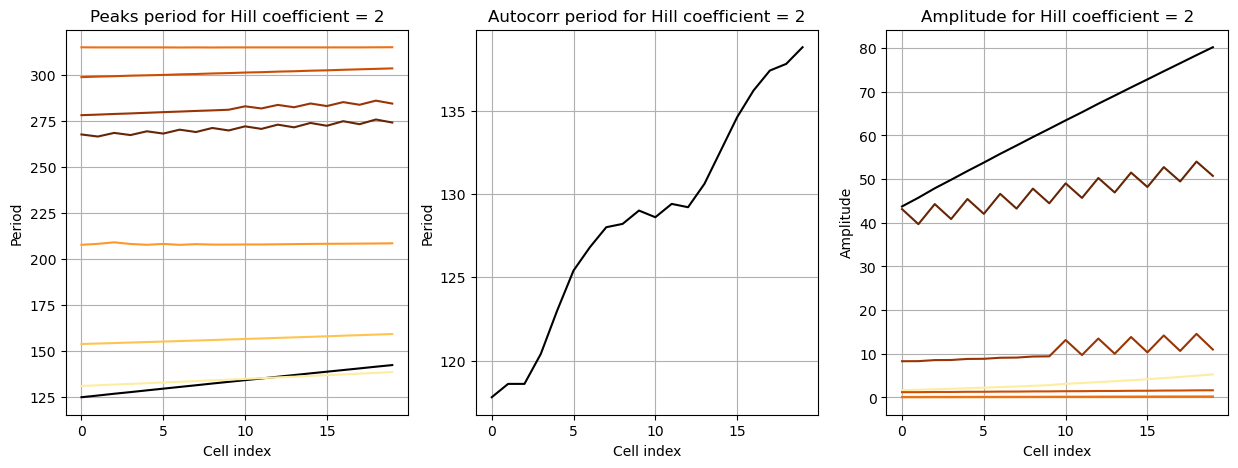

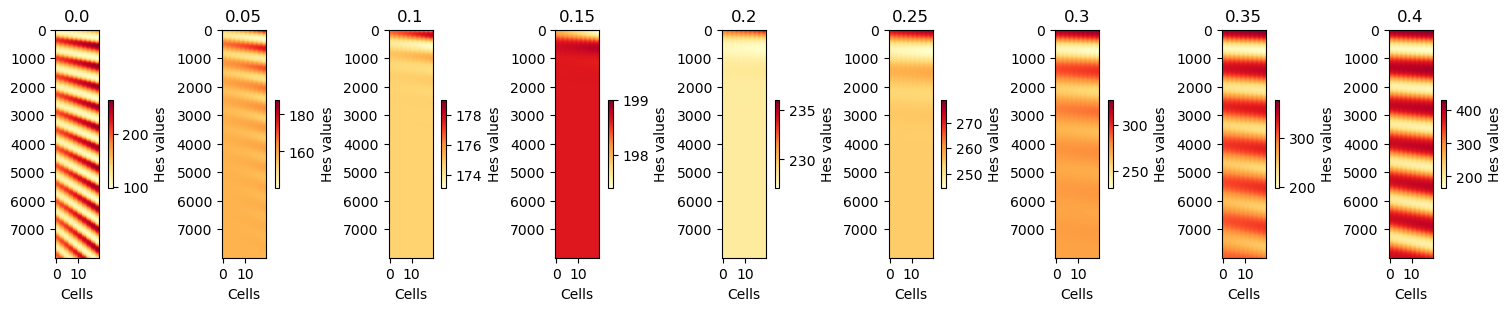

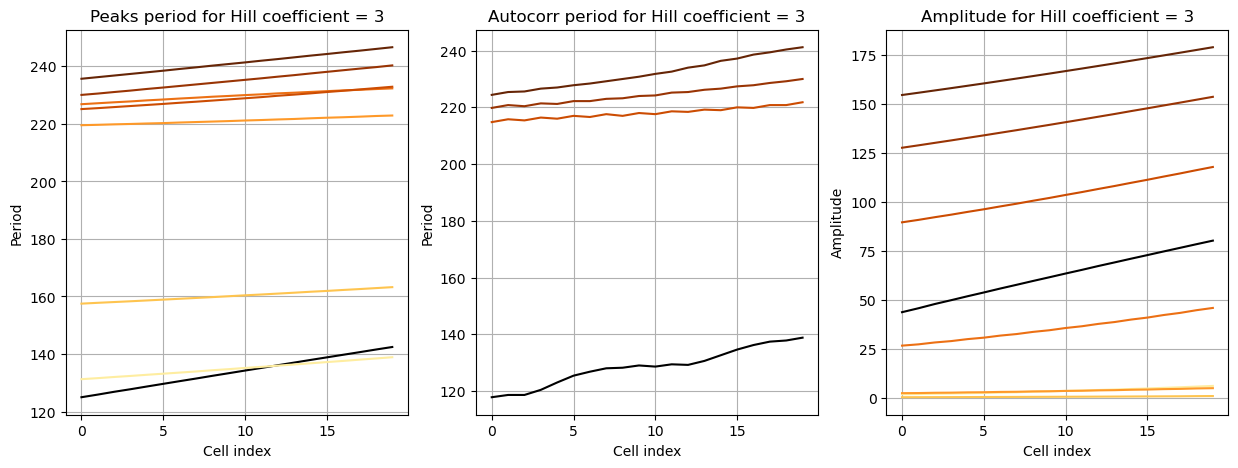

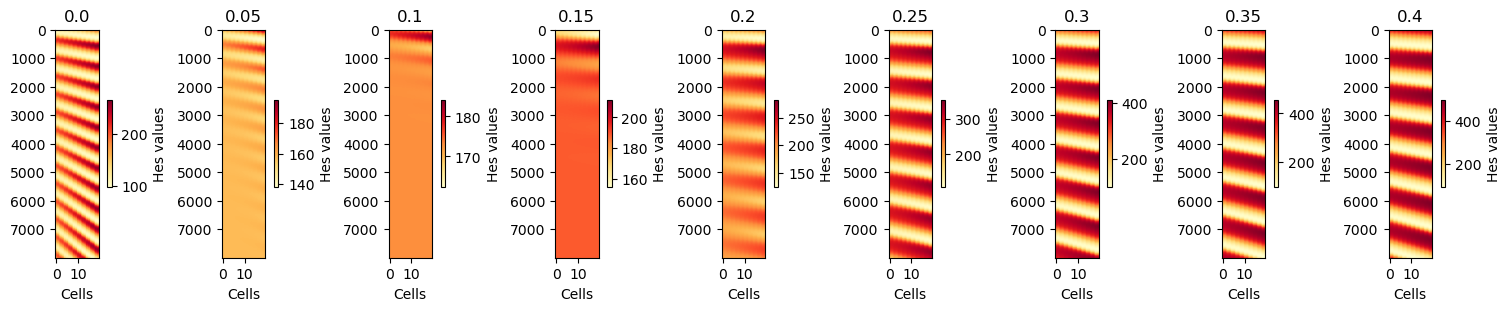

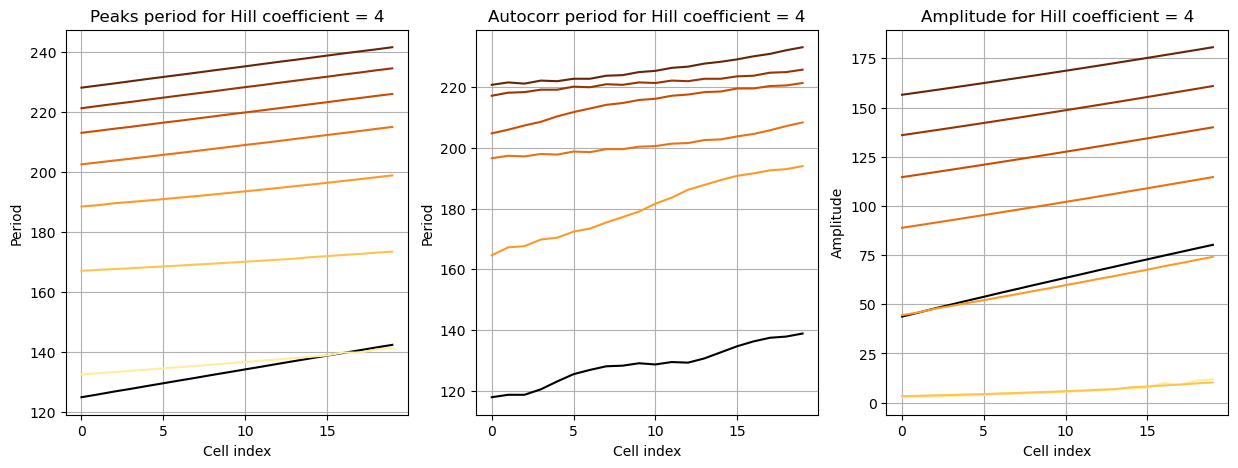

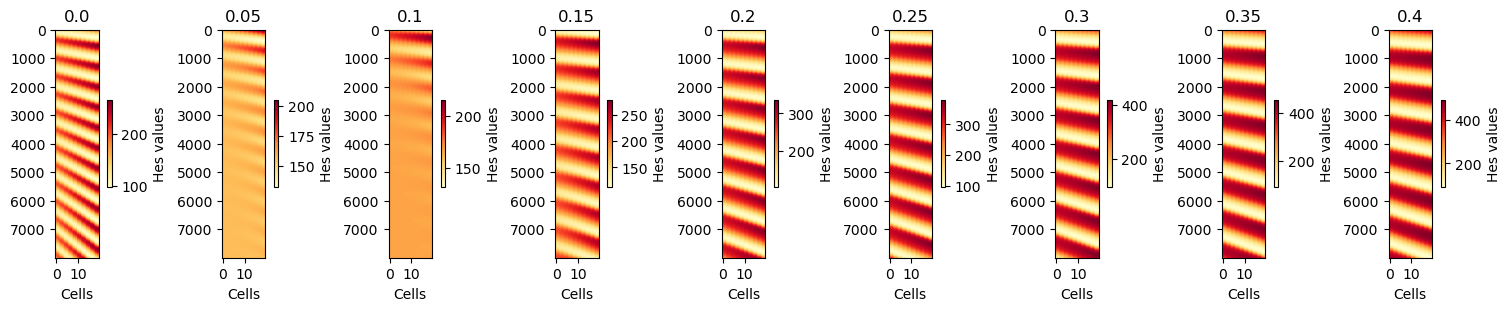

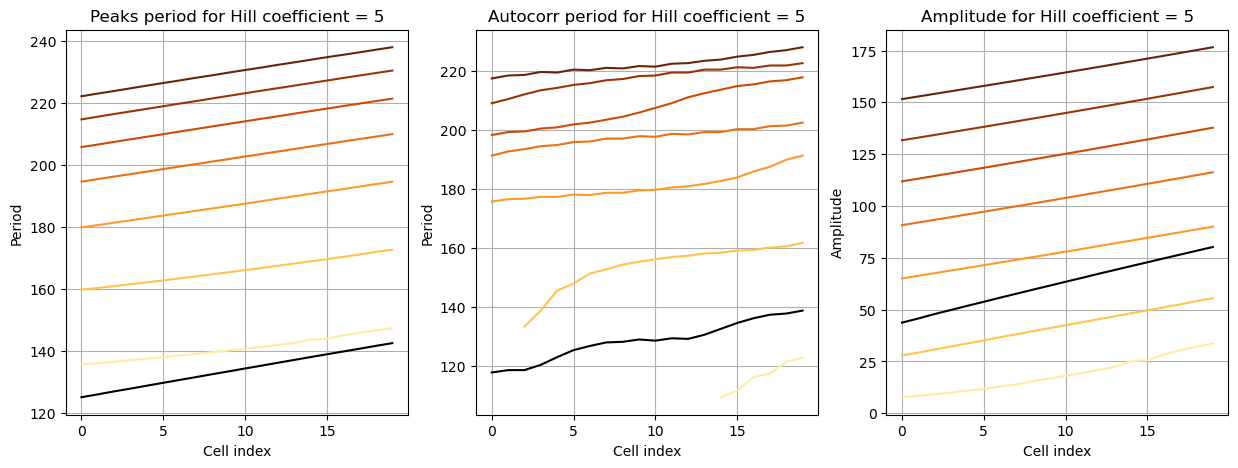

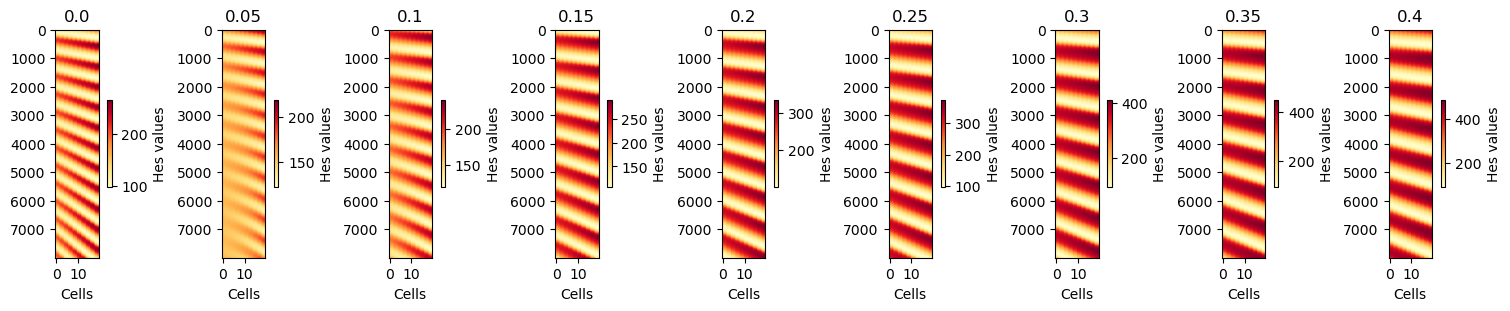

In [ ]:
for i in range(len(coeff_1D)):
    #plot of periods with peaks 
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.title(f'Peaks period for Hill coefficient = {coeff_1D[i]}')
    plt.plot(np.arange(lattice.P), periods_peaks[0,0,:], label = 'no coupling periods', color = 'black')
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()
    
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_peaks[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')


    # # plot of periods with autocorrelation
    # plt.subplot(1,3,2)
    # plt.title(f'Autocorr period for Hill coefficient = {coeff_1D[i]}')
    # plt.plot(np.arange(lattice.P), periods_autocorr[0,0,:], label = 'no coupling periods', color = 'black')

    # for j in range(1, len(coupling_strengths_1D)-1):
    #     plt.plot(np.arange(lattice.P), periods_autocorr[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')

    # plt.xlabel('Cell index')
    # plt.ylabel('Period')
    # plt.grid()
 

    # plot of amplitudes 
    plt.subplot(1,3,3)
    plt.title(f'Amplitude for Hill coefficient = {coeff_1D[i]}')
    plt.plot(np.arange(lattice.P), amplitudes[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), amplitudes[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.xlabel('Cell index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    #plot the kymograph for the different coupling strengths
    fig, ax = plt.subplots(1, int(len(coupling_strengths_1D)), figsize=(15,3), constrained_layout=True)

    for j in range(len(coupling_strengths_1D)):

        h_flat = results_1D[i,j,int(time_analysis):,:,0,0].reshape(int(num_tsteps-time_analysis), lattice.P)

        # Plot the first image
        im_j = ax[j].imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h_flat), vmax = np.ceil(np.max(h_flat)))
        #ax[j].set_ylabel('Time')
        ax[j].set_xlabel('Cells')
        ax[j].set_title(str(round(coupling_strengths_1D[j],2)))

        # Add colorbar for the first image
        cbar1 = fig.colorbar(im_j, ax=ax[j], orientation='vertical', fraction=0.1, pad=0.2)
        cbar1.set_label('Hes values')

    plt.show()



## Phase space 

In [19]:
for i in range(lattice.P):
    plt.figure()
    for j in range(lattice.Q):
        q_test = j
        plt.plot(m_h[:,i,q_test], m_d[:,i,q_test],  label = 'for P = ' + str(i))
    plt.xlabel('m_h')
    plt.ylabel('m_d')
    plt.legend()
    plt.show()

NameError: name 'm_h' is not defined

<Figure size 640x480 with 0 Axes>